# CNN pretrained ResNet50 model 

Source of idea: https://www.ejcancer.com/article/S0959-8049(19)30349-1/fulltext#secsectitle0050 Chapter 2.2 Methods

#### Pretrained ResNet50 CNN:

* ResNet50 Model: ResNet50 is a deep convolutional neural network architecture originally designed for image classification tasks. It consists of 50 layers, including convolutional layers, batch normalization, and skip connections (residual connections), which allow it to effectively learn from very deep networks. The model is pretrained on a large dataset (typically ImageNet) to capture a wide range of features from images

* Transfer Learning: In transfer learning, we start with a pretrained model (ResNet50 in this case) and fine-tune it for a specific task. By doing this, we leverage the knowledge the model has gained from the original dataset and adapt it to a new task, such as classifying skin lesions

## Imports and loading Data

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import cv2
import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 226
NUM_EPOCHS = 20

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path
FIELPATH_TESTOUTPUT= "./../data/testoutput/"

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

BATCH_SIZE = 32

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

lesion_id                    image_id    dx    dx_type   age     sex   
3543  HAM_0007627  aug_0t5v13ISIC_0029820.jpg   bcc      histo  80.0    male  \
2592  HAM_0001814            ISIC_0029170.jpg   mel      histo  65.0  female   
98    HAM_0005702            ISIC_0030381.jpg    nv  follow_up  45.0  female   
788   HAM_0005132            ISIC_0025837.jpg   bkl      histo  70.0  female   
4350  HAM_0002177  aug_GZ07DYISIC_0025612.jpg  vasc  consensus  45.0  female   
793   HAM_0004748            ISIC_0027513.jpg   bkl      histo  55.0    male   
3519  HAM_0004937  aug_Uu4nnOISIC_0026988.jpg   bcc      histo  60.0    male   
2660  HAM_0004642            ISIC_0025524.jpg   mel      histo  50.0  female   
4946  HAM_0004036  aug_SV9ByTISIC_0027727.jpg    df      histo  55.0    male   
4995  HAM_0002450  aug_pKrQAxISIC_0024318.jpg    df  consensus  65.0  female   
516   HAM_0003824            ISIC_0033091.jpg    nv      histo  15.0  female   
901   HAM_0006148            ISIC_0033987.jpg   bkl  consensus  80.0  female   
719   HAM_0002875            ISIC_0032050.jpg    nv  follow_up  60.0    male   
2266  HAM_0000553            ISIC_0034061.jpg   mel      histo  55.0  female   
1390  HAM_0000351            ISIC_0029559.jpg   bkl      histo  85.0    male   

         localization        dataset        dx_binary     dx_tertiary   
3543            chest      rosendahl      skin_cancer       malignant  \
2592             foot      rosendahl      skin_cancer       malignant   
98               back  vidir_molemax  not_skin_cancer          benign   
788              back   vidir_modern  not_skin_cancer  non-neoplastic   
4350             neck  vidir_molemax  not_skin_cancer  non-neoplastic   
793   upper extremity      rosendahl  not_skin_cancer  non-neoplastic   
3519             neck      rosendahl      skin_cancer       malignant   
2660  upper extremity    vienna_dias      skin_cancer       malignant   
4946  upper extremity      rosendahl  not_skin_cancer  non-neoplastic   
4995  lower extremity   vidir_modern  not_skin_cancer  non-neoplastic   
516   lower extremity   vidir_modern  not_skin_cancer          benign   
901              back   vidir_modern  not_skin_cancer  non-neoplastic   
719             trunk  vidir_molemax  not_skin_cancer          benign   
2266  lower extremity   vidir_modern      skin_cancer       malignant   
1390             back   vidir_modern  not_skin_cancer  non-neoplastic   

                                     image_path  
3543  ./../data/jpgs/aug_0t5v13ISIC_0029820.jpg  
2592            ./../data/jpgs/ISIC_0029170.jpg  
98              ./../data/jpgs/ISIC_0030381.jpg  
788             ./../data/jpgs/ISIC_0025837.jpg  
4350  ./../data/jpgs/aug_GZ07DYISIC_0025612.jpg  
793             ./../data/jpgs/ISIC_0027513.jpg  
3519  ./../data/jpgs/aug_Uu4nnOISIC_0026988.jpg  
2660            ./../data/jpgs/ISIC_0025524.jpg  
4946  ./../data/jpgs/aug_SV9ByTISIC_0027727.jpg  
4995  ./../data/jpgs/aug_pKrQAxISIC_0024318.jpg  
516             ./../data/jpgs/ISIC_0033091.jpg  
901             ./../data/jpgs/ISIC_0033987.jpg  
719             ./../data/jpgs/ISIC_0032050.jpg  
2266            ./../data/jpgs/ISIC_0034061.jpg  
1390            ./../data/jpgs/ISIC_0029559.jpg

## Setting up the image data generator for training and validation

#### Function for custom preprocessing of the images

In [3]:
def custom_preprocessing(np_image, image_size, show_image=False):
    # print the image
    # print("From custom_preprocessing: Image + shape before preprocessing:", np_image.shape)
    np_image = np_image.astype(np.uint8)
    
    #print(np_image)
    if show_image:
        plt.imshow(np_image.astype(np.uint8))
        plt.show()

    # rescale 
    np_image = np_image / 255.0

    # Using the image helper functions
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    
    if show_image:
        print("From custom_preprocessing: Image after center crop:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image

    if show_image:
        print("From custom_preprocessing: Image after after resizing:", np_image.shape)
        plt.imshow(np_image)
        plt.show()

    return np_image

#### Data Image generator for Train and Validation

In [5]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
    horizontal_flip=True,        # Randomly flip images horizontally
    vertical_flip=True,          # Randomly flip images vertically
    zoom_range=0.2,              # Randomly zoom in and out by up to 20%
    width_shift_range=0.2,       # Randomly shift images horizontally by up to 20%
    height_shift_range=0.2,      # Randomly shift images vertically by up to 20%
    rotation_range=30,           # Randomly rotate images by up to 30 degrees
    shear_range=0.2,             # Shear intensity (shear angle in radians)
    fill_mode='nearest'          # Strategy for filling in newly created pixels after transformations
)

datagen_validation = ImageDataGenerator(
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

train_data_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    color_mode='rgb',
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    #save_to_dir=FILEPATH_OUTPUT,
    #save_prefix="test_gen_",
    #save_format="jpg",
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE
)

Found 5254 validated image filenames belonging to 3 classes.
Found 1001 validated image filenames belonging to 3 classes.


### Control: Show some images from the train data set after preprocessing

In [6]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen)  
    plt.figure(figsize=(25, 25))
    length = len(labels)
    if length < 25:  
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i]  
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()

In [7]:
images, labels = next(train_data_generator)
print(images.min(), images.max(), images.dtype)

0.0 1.0 float32


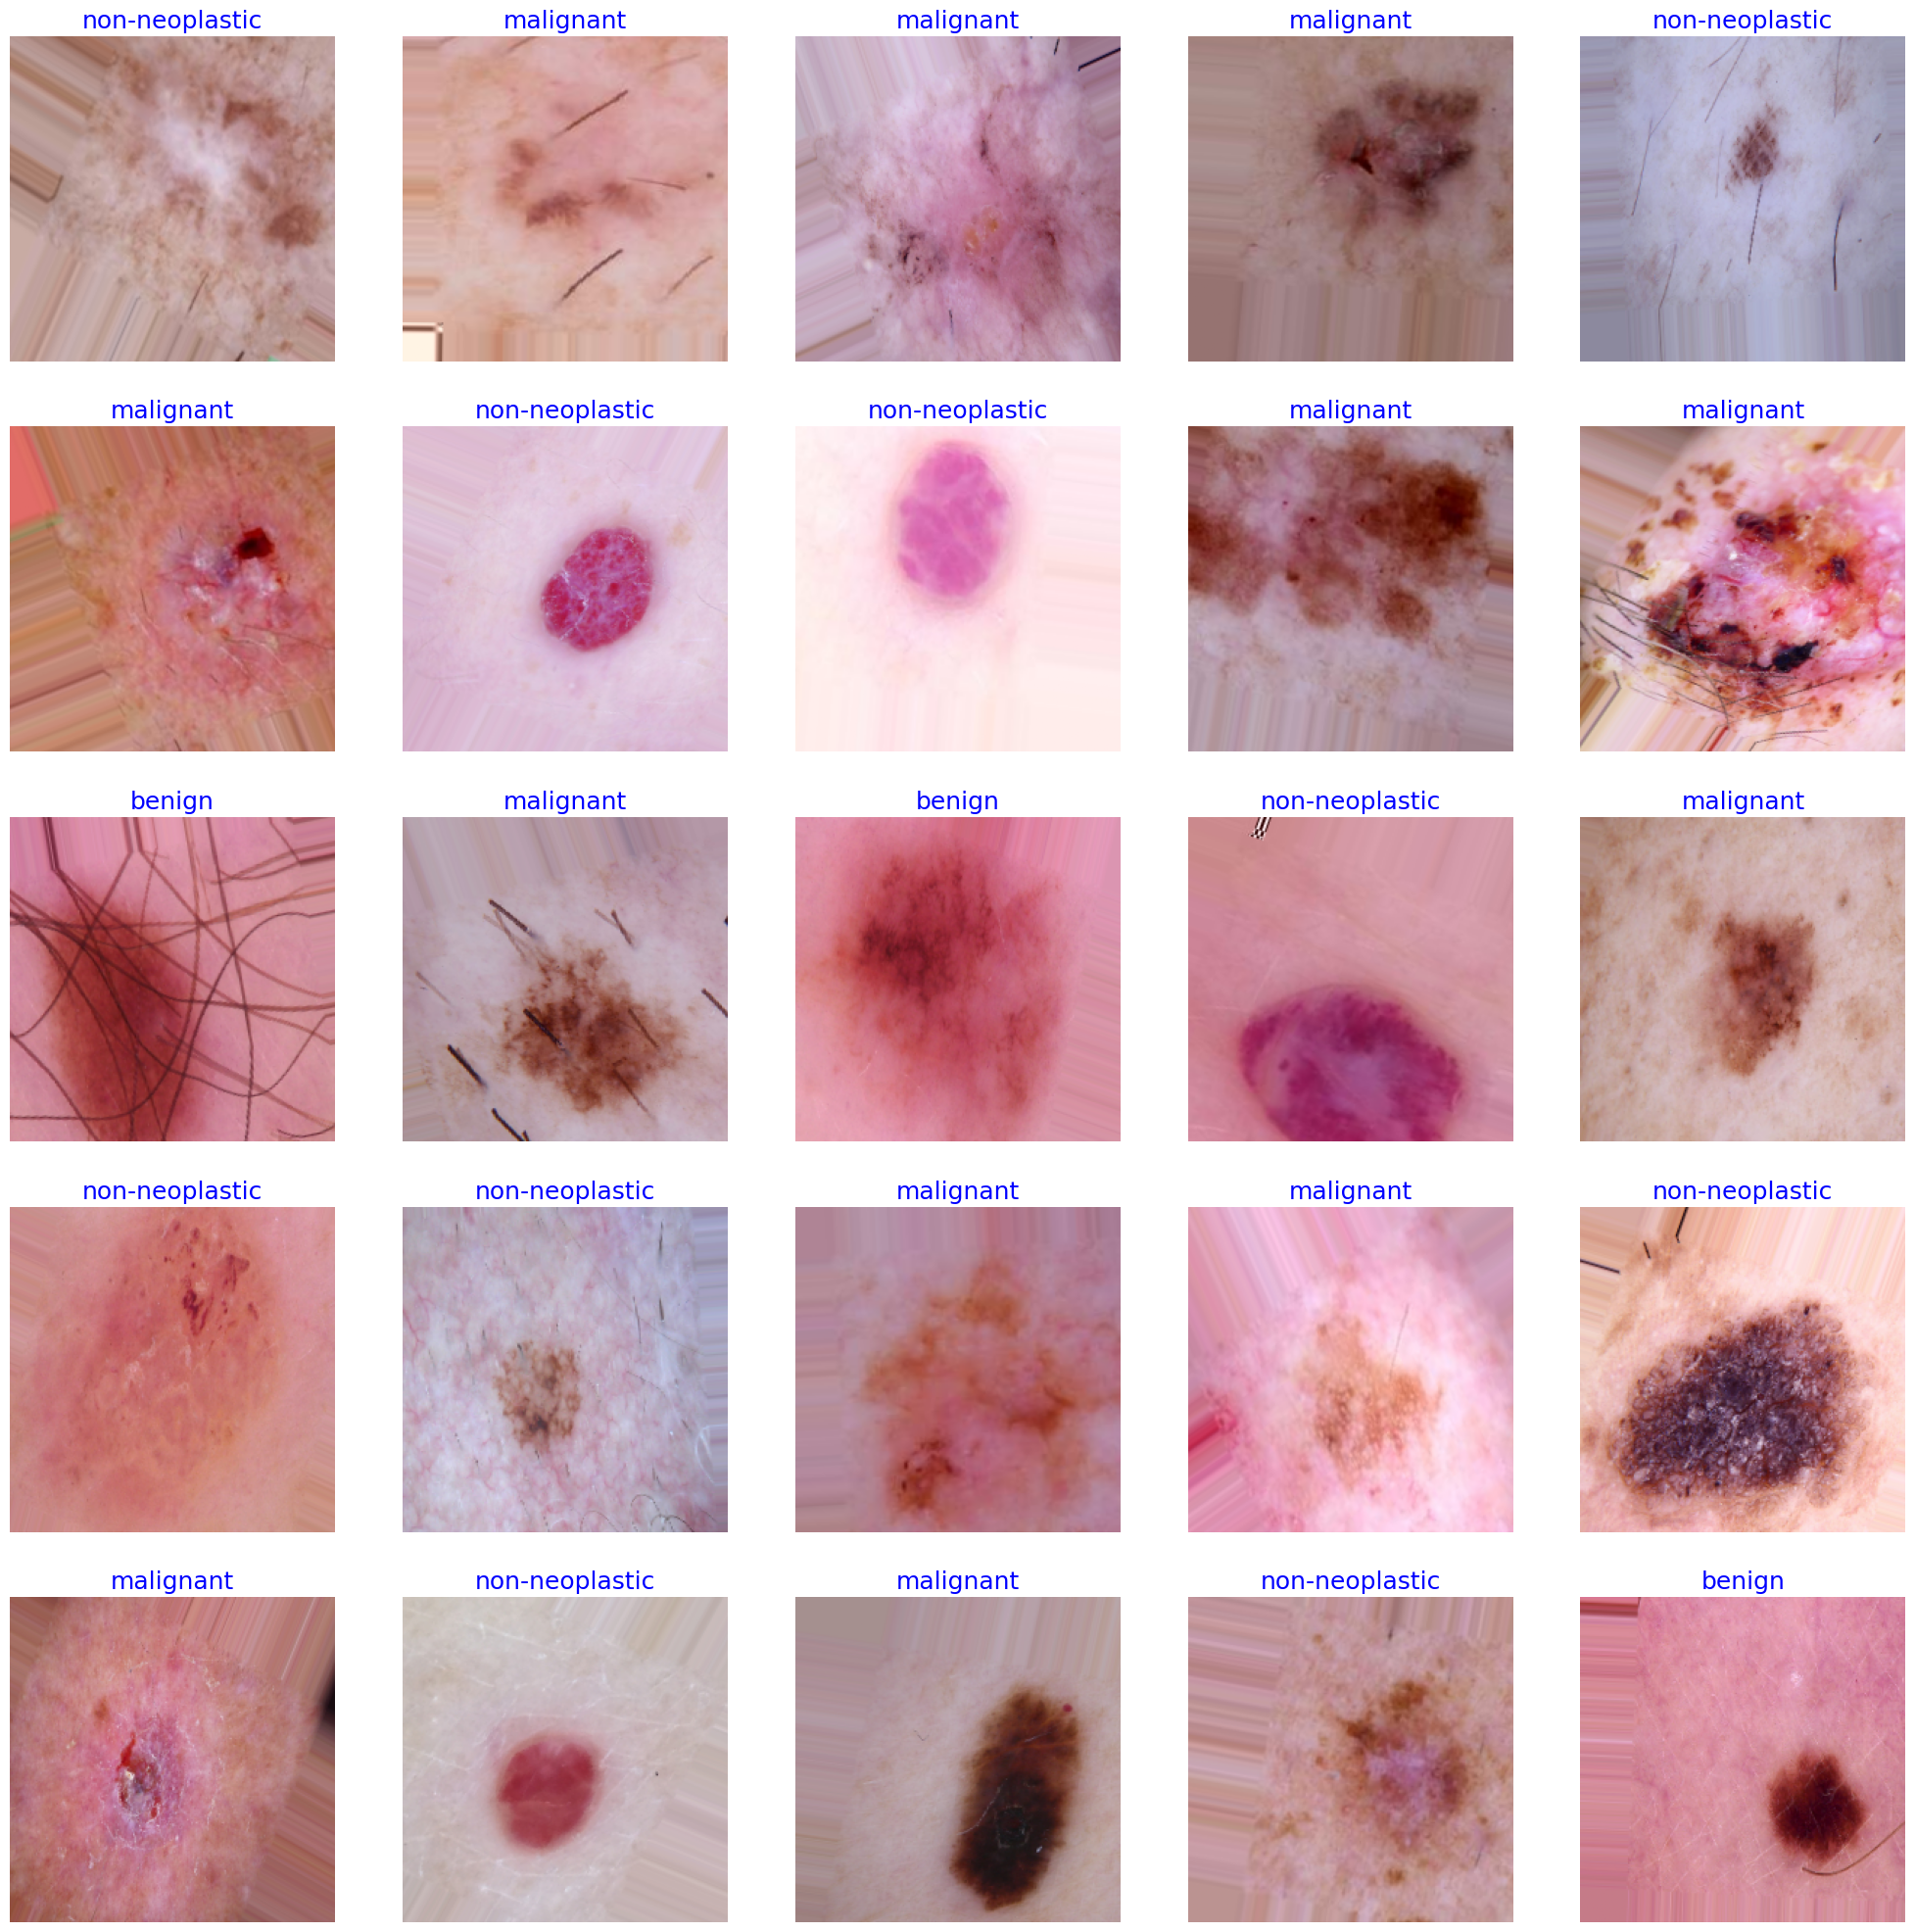

In [8]:
show_image_samples(train_data_generator)

## ResNet50


#### F1 score metric function for model compilation

In [9]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

#### focal loss function for model compilation (not yet in use)

In [10]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

#### Model architecture

In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import math

# Create a base ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)) # use the pretrained weights of the imagenet dataset, include_top=False means that we do not want to include the last layer of the model
num_classes = len(train_data_generator.class_indices) 

# Freeze layers in the base model
for layer in base_model.layers:
    layer.trainable = True

# Add custom layers for classification
x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(128, activation='relu')(x)
#x = Dropout(0.5)(x) 
#x = Conv2D(64, (3, 3), activation='relu')(x) --> this made things worse... could still be interesting to add a conv block here though...
#x = GlobalAveragePooling2D()(x) # GlobalAveragePooling2D reduces the spatial dimensions of the output
#x = Dense(1024, activation='relu')(x) # fully connected layer with 1024 neurons and ReLU activation, relu is used to introduce non-linearity
x= Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x, name='Resnet50_tertiary_earlystopping_valaccuracy_augmentation_in_train_data_generator')

# Compile the model with a custom optimizer (SGD with momentum)
custom_optimizer = tf.keras.optimizers.SGD(lr=1e-2, momentum=0.9)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_score])

# Print model summary
model.summary()

Model: "Resnet50_tertiary_earlystopping_valaccuracy_augmentation_in_train_data_generator"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)               

### Callback functions

#### Learning rate scheduler for model compilation

In [13]:
#defining a learning rate scheduler
import math
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.
    
    Args:
        epoch (int): The current epoch number.
        
    Returns:
        float: The learning rate for the current epoch.
    """
    initial_lr = 0.0001  # Initial learning rate
    drop = 0.5  # Learning rate drop factor
    epochs_drop = 5  # Number of epochs after which learning rate will drop

    # Calculate the learning rate for the current epoch
    lr = initial_lr * math.pow(drop, math.floor((1 + epoch) / epochs_drop))
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

#### Class weights 

In [14]:
from sklearn.utils import class_weight
import numpy as np
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(train_df[TARGET_LABEL]),
                                                    y=train_df[TARGET_LABEL])
class_weights = dict(enumerate(class_weights))
class_weights

{0: 2.335111111111111, 1: 0.7776791000592066, 2: 0.7776791000592066}

#### Early stopping

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor for early stopping
    patience=5,         # Number of epochs with no improvement to wait before stopping
    restore_best_weights=True  # Restore the model weights to the best epoch
    # set range in loss function
)

## Model Training

In [16]:
# Train the model
history = model.fit(
    train_data_generator,  # Training data generator
    epochs=NUM_EPOCHS,  # Number of training epochs
    verbose=1,  # Verbosity level during training (0, 1, or 2)
    batch_size=BATCH_SIZE,  # Batch size for training
    callbacks=[lr_scheduler, early_stopping],  # List of callbacks to apply during training
    validation_split=0.0,  # Fraction of the training data to use as validation data (0.0 means no split)
    validation_data=validation_generator,  # Validation data generator
    shuffle=True,  # Shuffle the training data before each epoch
    sample_weight=None,  # Optional sample weights for training data
    class_weight=class_weights,  # Optional class weights for loss calculation
    initial_epoch=0,  # Initial training epoch (useful for resuming training)
    steps_per_epoch=None,  # Number of steps per epoch (default is len(x_train) // batch_size)
    validation_steps=None,  # Number of steps for validation (default is len(x_val) // batch_size)
    validation_batch_size=None,  # Batch size for validation (default is batch_size)
    validation_freq=1,  # Frequency to validate the model on the validation set
    max_queue_size=10,  # Maximum size of the generator queue
    workers=-1,  # Maximum number of processes to generate data in parallel (-1 means all CPUs)
    use_multiprocessing=False  # Use multiprocessing for data generation (True or False)
)

Epoch 1/20
165/165 [==============================] - 1057s 6s/step - loss: 0.6654 - accuracy: 0.6938 - f1_score: 0.6755 - val_loss: 1.2806 - val_accuracy: 0.1359 - val_f1_score: 0.1378 - lr: 1.0000e-04
Epoch 2/20
165/165 [==============================] - 1394s 8s/step - loss: 0.4566 - accuracy: 0.7965 - f1_score: 0.7902 - val_loss: 1.0858 - val_accuracy: 0.2338 - val_f1_score: 0.0306 - lr: 1.0000e-04
Epoch 3/20
165/165 [==============================] - 1405s 9s/step - loss: 0.3724 - accuracy: 0.8386 - f1_score: 0.8346 - val_loss: 1.6497 - val_accuracy: 0.1439 - val_f1_score: 0.1432 - lr: 1.0000e-04
Epoch 4/20
165/165 [==============================] - 1391s 8s/step - loss: 0.3576 - accuracy: 0.8439 - f1_score: 0.8424 - val_loss: 1.7819 - val_accuracy: 0.2817 - val_f1_score: 0.2629 - lr: 1.0000e-04
Epoch 5/20
165/165 [==============================] - 1464s 9s/step - loss: 0.2652 - accuracy: 0.8816 - f1_score: 0.8816 - val_loss: 1.8298 - val_accuracy: 0.5085 - val_f1_score: 0.5063 - 

## Plotting accuracy and loss of train and validation set

#### Plotting Accuracy  of train and validation set

(0.0, 1.0)

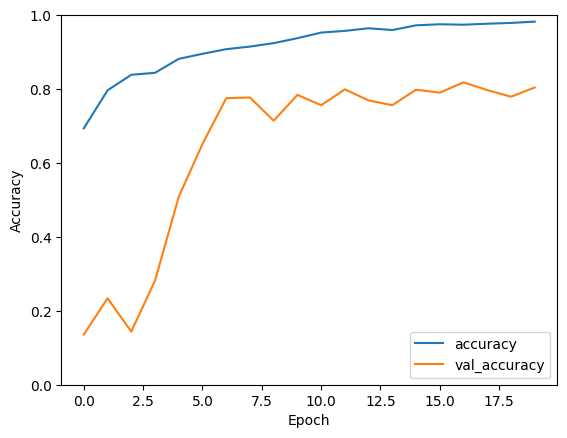

In [17]:
# plotting accuracy of train and validation
import matplotlib.pyplot as plt
mh.model_plot_accuracy(history)
plt.ylim(0,1)

#### F1 Score of train and validation set

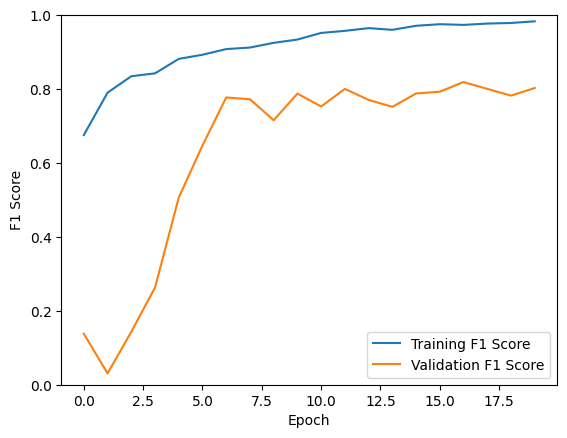

In [26]:
import matplotlib.pyplot as plt

# Assuming you have a variable named 'history' containing the training history
# (e.g., history = model.fit(...) where model is your Keras model)
# You can access the loss values from 'history.history'

# Plot the loss functions
plt.plot(history.history['f1_score'], label='Training F1 Score')
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.ylim([0, 1])  # Set the y-axis limits as needed
plt.legend(loc='lower right')  # You can adjust the legend position
plt.show()  # Show the plot

#### Plotting Loss of train and validation set

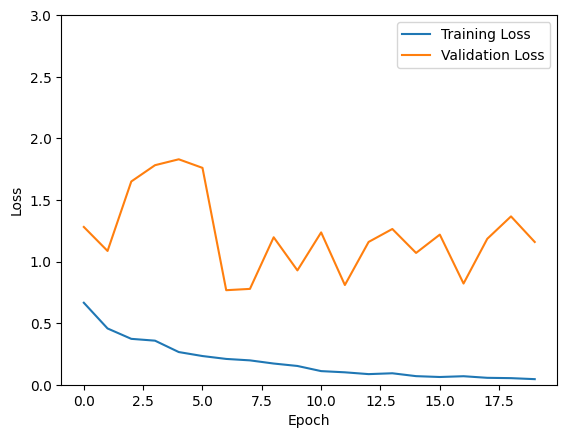

In [22]:
import matplotlib.pyplot as plt

# Plot the loss functions
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 3])  # Set the y-axis limits as needed
plt.legend(loc='upper right')  # You can adjust the legend position
plt.show()  # Show the plot


## Evaluating the model on the test set

 > Evaluating model Resnet50_tertiary_earlystopping_valaccuracy_augmentation_in_train_data_generator:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 47s 1s/step
 > Model predictions obtained.
 > Macro AUC: 0.9467318106348364
 > Micro AUC: 0.9489787889291277


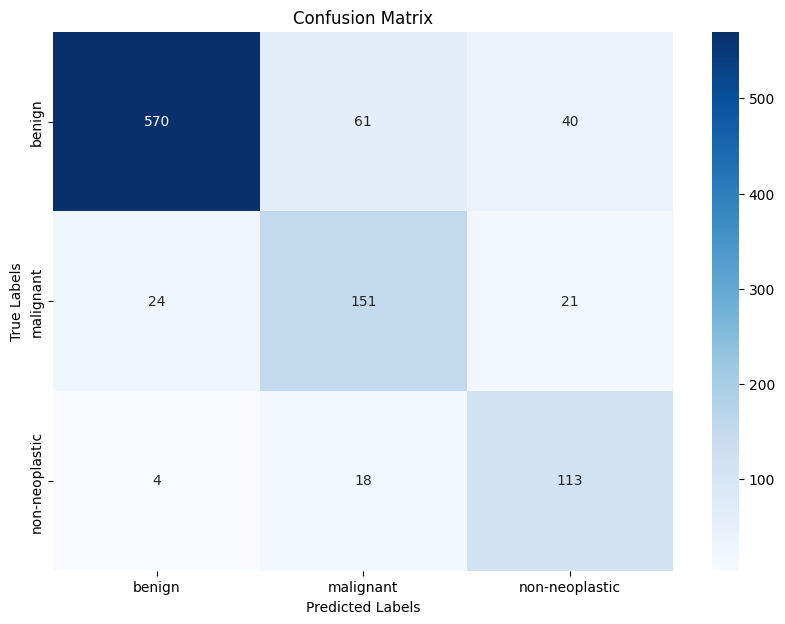



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       671
           1       0.66      0.77      0.71       196
           2       0.65      0.84      0.73       135

    accuracy                           0.83      1002
   macro avg       0.75      0.82      0.78      1002
weighted avg       0.85      0.83      0.84      1002

 > Evaluating model on test set...
32/32 [==============================] - 47s 1s/step - loss: 0.8830 - accuracy: 0.8323 - f1_score: 0.8276
loss: 0.8829754590988159
accuracy: 0.832335352897644
f1_score: 0.8276072144508362
 > Done.


([{'loss': 0.8829754590988159},
  {'accuracy': 0.832335352897644},
  {'f1_score': 0.8276072144508362}],
 array([[570,  61,  40],
        [ 24, 151,  21],
        [  4,  18, 113]]),
 (0.9489787889291277, 0.9467318106348364))

In [18]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [19]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/janicepelzer/Documents/neuefische/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
